In [45]:
# Import dependencies
import os
import wfdb
import numpy as np
from pydub import AudioSegment
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import parselmouth

In [54]:
# CONSTANTS

# Since audio data, need signed bit integer
# According to dataset: 32-bit
SIGNED_32BIT = 2**31 - 1

# According to dataset: 8000Hz
SAMPLING_FREQ = 8000

# Since 32-bit, 8bits/byte
SAMPLE_WIDTH = 4

## Import data

In [4]:
# Raw dataset file path
rawdata_path = "resources/voiced_dataset/"

# Get all the files in the directory
files = os.listdir(rawdata_path)

# Create lists to check dataset
voice_info = []
voice_file = []

# Loop through each file
for file in files:
    
    # Look through voice files only
    if file.startswith("voice"):
        
        # Isolate the info text files
        if file.endswith("-info.txt"):
            voice_id = file.split("-")[0]
            voice_info.append(voice_id)
        
        # Isolate the voice text files
        elif file.endswith(".txt"):
            voice_id = file.split(".")[0]
            voice_file.append(voice_id)

# Confirm each sample has a signal and info file
print(f'Info file: {len(voice_info)}')
print(f'Signal file: {len(voice_file)}')

Info file: 208
Signal file: 208


### Convert wfdb to wav

In [5]:
# Convert to a wav file
for file in files:
    
    # Extract .hea files only
    if file.startswith("voice") and file.endswith(".hea"):
        voice_id = file.split(".")[0]
        
        # Get the record name
        record_name = rawdata_path + voice_id
        
        # Read the wfdb record
        record = wfdb.rdrecord(record_name)
        
        # Get the signal data and sampling freq (fs)
        signal_data = record.p_signal
        fs = record.fs
        
        # Find the min and max of the signal data
        signal_min = np.min(signal_data)
        signal_max = np.max(signal_data)
        
        # Normalise and scale to 32-bit range
        normalised_signal = (signal_data - signal_min) / (signal_max - signal_min)
        normalised_signal = (SIGNED_32BIT * normalised_signal).astype(np.int32)
        
        # Create an AudioSegment from the normalised signal data
        audio_segment = AudioSegment(
            normalised_signal.tobytes(),
            frame_rate = fs,
            sample_width = SAMPLE_WIDTH,
            channels = 1 # mono, not stereo
        )
        
        # Save as a wav file
        output_filename = f'resources/audio_files/{voice_id}.wav'
        audio_segment.export(output_filename, format='wav')

### Convert info text file to DataFrame

In [67]:
# Display an example of the info text file
sample_file = rawdata_path + "voice001-info.txt"

# Read the text file
with open(sample_file, 'r') as file:
    for line in file:
        print(line.strip())

ID	voice001

Age:	32
Gender:	m
Diagnosis:	hyperkinetic dysphonia
Occupation status:	Researcher


Voice Handicap Index (VHI) Score:	15
Reflux Symptom Index (RSI) Score:	5


Smoker:	no
Number of cigarettes smoked per day:	NU

Alcohol consumption:	casual drinker
Number of glasses containing alcoholic beverage drinked in a day	NU
Amount of water's litres drink every day:	1,5

Eating habits:
Carbonated beverages:	almost never
Amount of glasses drinked in a day	NU
Tomatoes:	sometimes
Coffee:	almost always
Number of cups of coffee drinked in a day	4
Chocolate:	almost never
Gramme of chocolate eaten in  a day	NU
Soft cheese:	sometimes
Gramme of soft cheese eaten in a day	NU
Citrus fruits:	sometimes
Number of citrus fruits eaten in a day	NU


In [6]:
# Initialise the list to hold dictionaries
metadata_list = []

# Parse the data in the info files
for file in files:
    
    # Initialise the dictionary to store the info
    metadata_dict = dict()
    
    # Look through info files only
    if file.startswith("voice") and file.endswith("-info.txt"):
        
        # Read the text file
        with open(rawdata_path + file, 'r') as file:
            for line in file:
                
                # Split each line into a key-value pair using delimiter
                key, value = map(str.strip, line.split("\t"))
                
                # Ignore the empty lines by checking whitespaces
                if not line.strip():
                    continue
                else:
                    # Remove the colon
                    key = key.replace(":", "")
                    
                    # Load the data to a dictionary
                    metadata_dict[key] = value
                    
            # Append the dictionary to the list
            metadata_list.append(metadata_dict)

# Convert the list to a DataFrame
metadata_df = pd.DataFrame(metadata_list)
metadata_df.head()

,ID,Age,Gender,Diagnosis,Occupation status,Voice Handicap Index (VHI) Score,Reflux Symptom Index (RSI) Score,Smoker,Number of cigarettes smoked per day,Alcohol consumption,...,Amount of glasses drinked in a day,Tomatoes,Coffee,Number of cups of coffee drinked in a day,Chocolate,Gramme of chocolate eaten in a day,Soft cheese,Gramme of soft cheese eaten in a day,Citrus fruits,Number of citrus fruits eaten in a day
0,voice100,24,m,healthy,NU,0,5,no,NU,casual drinker,...,NU,never,always,3,sometimes,NU,almost always,NU,never,NU
1,voice101,60,m,healthy,NU,80,10,no,NU,nondrinker,...,NU,sometimes,always,4,sometimes,NU,sometimes,NU,never,NU
2,voice192,22,m,hyperkinetic dysphonia,Cook,0,10,no,NU,nondrinker,...,NU,sometimes,always,NU,always,NU,sometimes,NU,almost always,NU
3,voice193,46,f,hyperkinetic dysphonia,Housewife,0,36,yes,15,casual drinker,...,NU,sometimes,always,2,sometimes,NU,sometimes,NU,sometimes,NU
4,voice008,51,f,reflux laryngitis,Researcher,19,15,no,NU,casual drinker,...,NU,almost always,always,2,almost always,20g,sometimes,100 gr,almost always,1


### Signal Visualisations

In [7]:
# Retrieve the audio files
audio_path = "resources/audio_files/"
audio_files = os.listdir(audio_path)

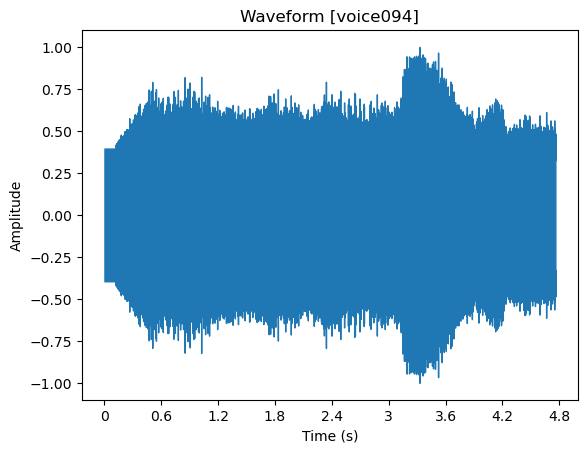

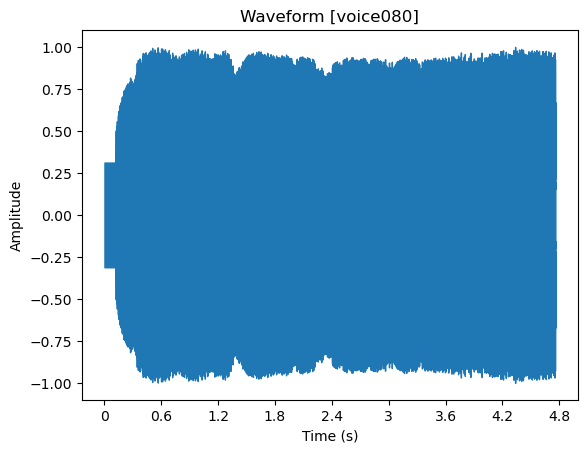

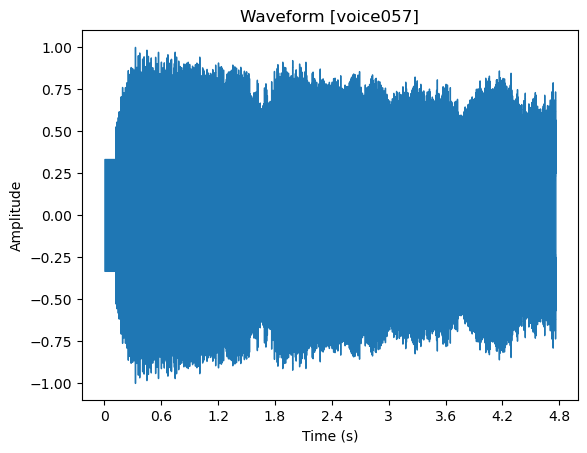

In [8]:
# Display the first 3 waveforms
for file in audio_files[:3]:
    
    # Load the file
    y, sr = librosa.load(
        audio_path + file, # full file path
        sr = None # preserve sampling rate
    )
    
    # Plot the waveform
    librosa.display.waveshow(y, sr=sr)
    
    # Add labels
    plt.title(f'Waveform [{file.split(".")[0]}]')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    # Display the waveform
    plt.show()

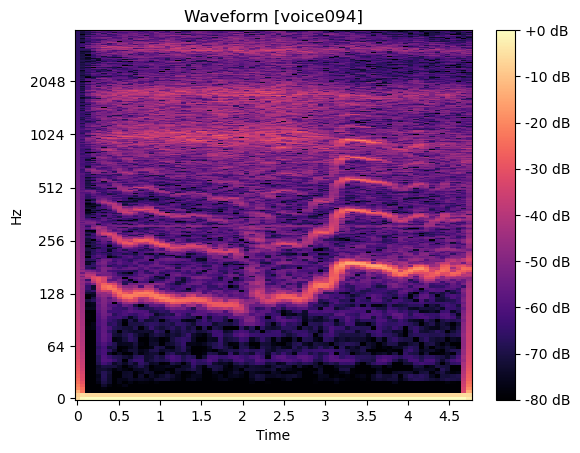

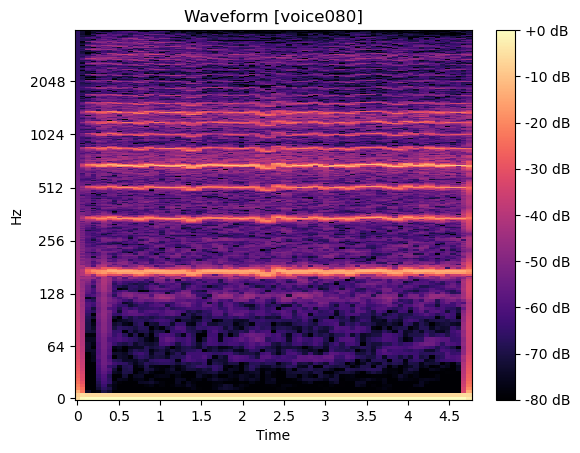

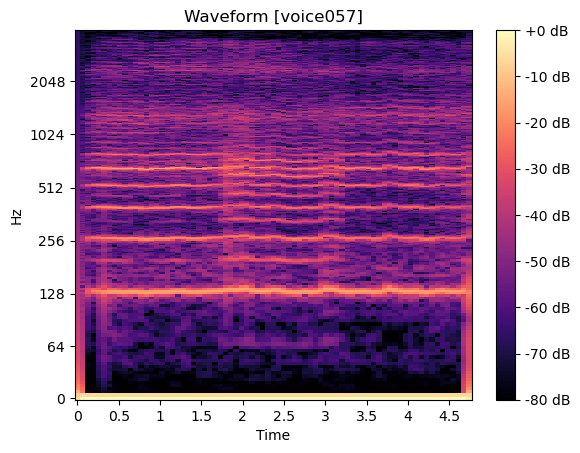

In [10]:
# Display the first 3 spectrograms
for file in audio_files[:3]:
    
    # Load the file
    y, sr = librosa.load(
        audio_path + file, # full file path
        sr = None # preserve sampling rate
    )
    
    # Plot the spectrogram
    D = librosa.amplitude_to_db(
        np.abs(librosa.stft(y)),
        ref = np.max
    )

    # Plot the spectrogram
    librosa.display.specshow(
        D,
        sr = sr,
        x_axis='time',
        y_axis='log' # can also choose: linear
    )
    
    # Add labels
    plt.title(f'Waveform [{file.split(".")[0]}]')
    plt.colorbar(format='%+2.0f dB')
    
    plt.show()

## Formants using Parselmouth

In [64]:
for file in audio_files[:3]:
    
    # Load the audio file
    sound = parselmouth.Sound(audio_path + file)
    
    # Extract the formants - Burg's method
    formants = sound.to_formant_burg()
    print(formants)
    
    # Define fundamental freq limits
    f0_min = 50
    f0_max = SAMPLING_FREQ / 2 # Nyquist frequency
    
    # Compute the occurrences of periodic instances
    pointProcess = parselmouth.praat.call(
        sound,
        "To PointProcess (periodic, cc)",
        f0_min,
        f0_max
    )
    
    # Compute the formants
    formants = parselmouth.praat.call(
        sound,
        "To Formant (burg)",
        0.0025,
        5,
        5000,
        0.025,
        50
    )
    
    numPoints = parselmouth.praat.call(pointProcess, "Get number of points")
    f1_list = []
    f2_list = []
    f3_list = []
    for point in range(0, numPoints):
        point += 1
        t = parselmouth.praat.call(pointProcess, "Get time from index", point)
        f1 = parselmouth.praat.call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
        f2 = parselmouth.praat.call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
        f3 = parselmouth.praat.call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
        f1_list.append(f1)
        f2_list.append(f2)
        f3_list.append(f3)
        
    print(len(f1_list), len(f2_list), len(f3_list))

Object type: Formant
Object name: <no name>
Date: Fri Dec 22 13:01:00 2023

Time domain:
   Start time: 0 seconds
   End time: 4.76 seconds
   Total duration: 4.76 seconds
Time sampling:
   Number of frames: 754
   Time step: 0.00625 seconds
   First frame centred at: 0.026874999999999538 seconds

638 638 638
Object type: Formant
Object name: <no name>
Date: Fri Dec 22 13:01:01 2023

Time domain:
   Start time: 0 seconds
   End time: 4.76 seconds
   Total duration: 4.76 seconds
Time sampling:
   Number of frames: 754
   Time step: 0.00625 seconds
   First frame centred at: 0.026874999999999538 seconds

791 791 791
Object type: Formant
Object name: <no name>
Date: Fri Dec 22 13:01:01 2023

Time domain:
   Start time: 0 seconds
   End time: 4.76 seconds
   Total duration: 4.76 seconds
Time sampling:
   Number of frames: 754
   Time step: 0.00625 seconds
   First frame centred at: 0.026874999999999538 seconds

419 419 419


## Harmonics using Librosa

voice094.wav
1025 [0.00000000e+00 3.90625000e+00 7.81250000e+00 ... 3.99218750e+03
 3.99609375e+03 4.00000000e+03]
12 75
voice080.wav
1025 [0.00000000e+00 3.90625000e+00 7.81250000e+00 ... 3.99218750e+03
 3.99609375e+03 4.00000000e+03]
12 75
voice057.wav
1025 [0.00000000e+00 3.90625000e+00 7.81250000e+00 ... 3.99218750e+03
 3.99609375e+03 4.00000000e+03]
12 75
voice043.wav
1025 [0.00000000e+00 3.90625000e+00 7.81250000e+00 ... 3.99218750e+03
 3.99609375e+03 4.00000000e+03]
12 75


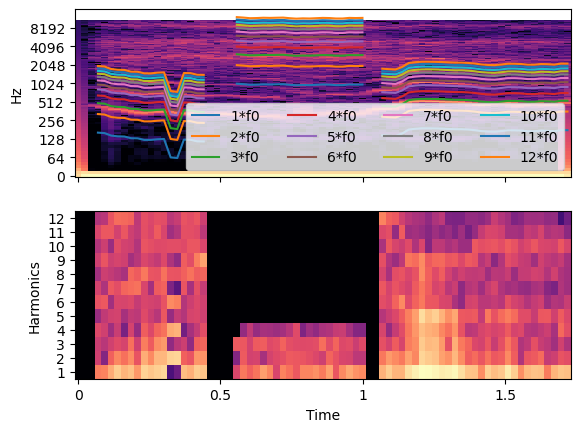

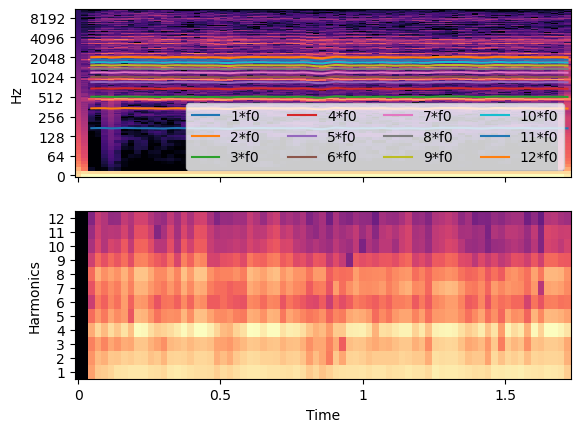

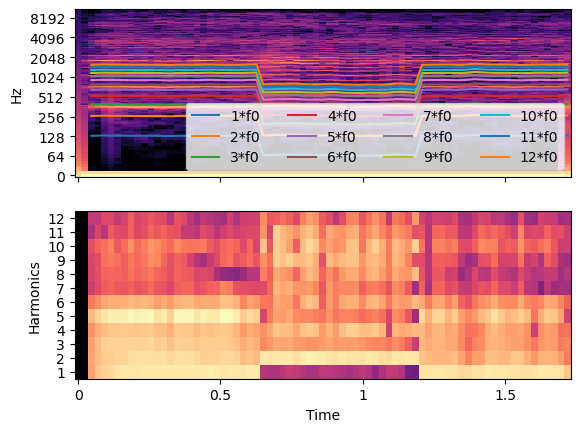

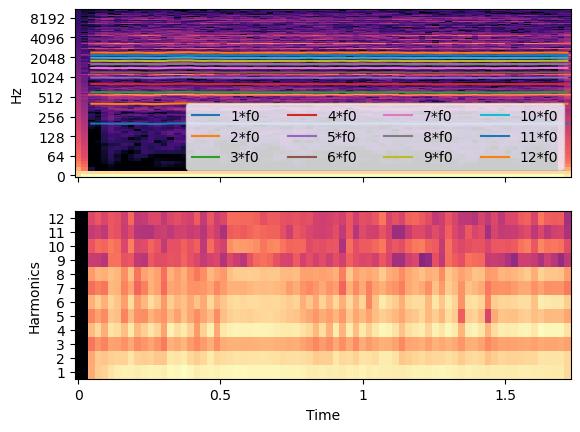

In [44]:
# Get the fundamental frequency (f0)
for file in audio_files[:4]:
    print(file)
    
    # Load the file
    y, sr = librosa.load(
        audio_path + file, # full file path
        sr = None # preserve sampling rate
    )

    # Estimate f0
    f0, voicing, voicing_probability = librosa.pyin(
        y = y,
        sr = sr,
        fmin = 50,
        fmax = sr / 2 # Nyquist frequency
    )
    
    # Magnitude spectrogram - freq content of signal over time
    S = np.abs(librosa.stft(y))
    
    # Get the frequency bins
    freqs = librosa.fft_frequencies(sr=sr)
    print(len(freqs), freqs)
    
    # Harmonic analysis (first 12)
    harmonics = np.arange(1, 13)
    f0_harmonics = librosa.f0_harmonics(
        S,
        freqs = freqs,
        f0 = f0,
        harmonics = harmonics
    )
    print(len(f0_harmonics), len(f0_harmonics[0]))
    
    fig, ax =plt.subplots(nrows=2, sharex=True)
    librosa.display.specshow(
        librosa.amplitude_to_db(S, ref=np.max),
        x_axis='time',
        y_axis='log',
        ax=ax[0]
    )
    times = librosa.times_like(f0)
    for h in harmonics:
        ax[0].plot(times, h * f0, label=f"{h}*f0")
    ax[0].legend(ncols=4, loc='lower right')
    ax[0].label_outer()

    librosa.display.specshow(
        librosa.amplitude_to_db(f0_harmonics, ref=np.max),
        x_axis = 'time',
        ax = ax[1]
    )
    ax[1].set_yticks(harmonics-1)
    ax[1].set_yticklabels(harmonics)
    ax[1].set(ylabel='Harmonics')

In [38]:
metadata_df.loc[metadata_df['ID'].isin(['voice094', 'voice080', 'voice057', 'voice043'])]

,ID,Age,Gender,Diagnosis,Occupation status,Voice Handicap Index (VHI) Score,Reflux Symptom Index (RSI) Score,Smoker,Number of cigarettes smoked per day,Alcohol consumption,...,Amount of glasses drinked in a day,Tomatoes,Coffee,Number of cups of coffee drinked in a day,Chocolate,Gramme of chocolate eaten in a day,Soft cheese,Gramme of soft cheese eaten in a day,Citrus fruits,Number of citrus fruits eaten in a day
27,voice057,68,m,reflux laryngitis,Pensioner,11,6,No,NU,casual drinker,...,NU,almost never,always,4,sometimes,NU,sometimes,NU,almost always,1
71,voice080,57,f,hyperkinetic dysphonia (Prolapse),Researcher,40,16,yes,20,habitual drinker,...,2 for mounth,almost always,almost always,3,sometimes,20 gr,sometimes,100 gr,almost always,1
151,voice043,38,f,hypokinetic dysphonia,Researcher,17,41,No,NU,nondrinker,...,NU,sometimes,sometimes,1,sometimes,NU,sometimes,NU,sometimes,NU
158,voice094,67,f,hypokinetic dysphonia (glottic insufficiency),NU,28,17,no,NU,casual drinker,...,NU,sometimes,always,3,always,NU,almost never,NU,sometimes,NU


In [26]:
for file in audio_files[:3]:
    
    # Load the file
    y, sr = librosa.load(
        audio_path + file, # full file path
        sr = None # preserve sampling rate
    )

    # Extract harmonics
    harmonic, percussive = librosa.effects.hpss(y)
    # print(len(harmonic), harmonic)
    
    # Extract pitches
    # pitches, magnitudes = librosa.core.piptrack(
    #     y = harmonic,
    #     sr = sr
    # )
    
    # Get the indices
    hps = librosa.effects.harmonic(y)
    print(len(hps), hps)
    print(len(harmonic), harmonic)
    

    
    # Create the time axis
    # time = np.arange(0, len(y)) / sr
    
    # Plot the original waveform and harmonics
    # plt.plot(time, y, label = 'Original Signal')
    # plt.plot(
    #     time,
    #     harmonic,
    #     label = 'Harmonic Component',
    #     linestyle = '--'
    # )
    # plt.show()

38080 [0.36294314 0.32321435 0.29151872 ... 0.3342739  0.33673522 0.34240487]
38080 [0.36294314 0.32321435 0.29151872 ... 0.3342739  0.33673522 0.34240487]


ParameterError: Wavelet basis with max frequency=3951.0664100489926 would exceed the Nyquist frequency=4000.0. Try reducing the number of frequency bins.